# Utility

In [4]:
import msgpack
import open3d as o3d
import trimesh
import point_cloud_utils as pcu  # downsampling
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt
import numba
from joblib import Parallel, delayed  # multiprocessing
import multiprocessing
import copy
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from scipy.spatial.transform import Rotation
import tempfile
import gmsh
import meshio

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

print(f"open3d :{o3d.__version__}")
print(f"trimesh:{trimesh.__version__}")
print(f"numba  :{numba.__version__}")
###########################################################


def NormalizeSignedDistance(signed_distance, zero_map_to=0.5):
    """
    Normalize to 0-1
    min-0 map to 0-0.5
    0-max map to 0.5-1
    """
    is_negative = signed_distance <= 0

    normalized_distance = np.zeros_like(signed_distance)
    minimum = signed_distance.min()
    maximum = signed_distance.max()
    normalized_distance[is_negative] = (
        signed_distance[is_negative] - minimum) / np.abs(minimum) * zero_map_to
    normalized_distance[~is_negative] = zero_map_to + \
        signed_distance[~is_negative]/np.abs(maximum)*(1-zero_map_to)
    return normalized_distance

# # # https://matplotlib.org/tutorials/colors/colormaps.html
# # cmap = plt.cm.get_cmap('hot')
# sd = np.linspace(-2,2,51)
# mapped = NormalizeSignedDistance(sd, zero_map_to=0.0)
# plt.plot(sd,mapped)


coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=60, origin=[0, 0, 0])


def rotate_view(vis):
    ctr = vis.get_view_control()
    ctr.rotate(1.0, 0.0)
    return False

# @numba.jit(["float64[:,:](float64[:,::1], float64,int64)",
#             "float64[:,:](float64[:,:], float64,int64)"],nopython=True)


@numba.jit([
    (numba.types.Array(numba.types.float64, 2, 'C', readonly=True),
     numba.types.float64, numba.types.int64),
    (numba.types.Array(numba.types.float64, 2, 'C', readonly=False), numba.types.float64, numba.types.int64)],
    nopython=True, nogil=True)
def UniformRandomAroundPoints(points, radius, num_per_grid=50):
    """
    sample random points uniformly (along xyz) around an arry of n points (n,3)
    input:
        points: (nx3) numpy array of xyz
        radius: (float scalar) the radius along x,y,z direction to randomly sample the points
        num_per_grid:(float scalar) number of random points to sample per specified point
    """
#     num = points.shape[0]*num_per_grid
#     xyz = np.random.uniform(-radius,radius+np.nextafter(0,1),num*3).reshape((num,3))
#     xyz = xyz + points.repeat(num_per_grid,axis=0)
    num_grid = points.shape[0]
    xyz = np.empty((num_grid*num_per_grid, 3), dtype=np.float64)
#     for i,point in enumerate(points):
    for i in range(num_grid):
        point = points[i]
        start = num_per_grid*i
        end = start+num_per_grid
        xyz[start:end, 0] = np.random.uniform(
            point[0]-radius, point[0]+radius, num_per_grid)
        xyz[start:end, 1] = np.random.uniform(
            point[1]-radius, point[1]+radius, num_per_grid)
        xyz[start:end, 2] = np.random.uniform(
            point[2]-radius, point[2]+radius, num_per_grid)
    return xyz


# example, compile
_ = UniformRandomAroundPoints(np.zeros((2, 3)), 1.0, num_per_grid=5)
_ = UniformRandomAroundPoints(np.ascontiguousarray(
    np.zeros((2, 3))), 1.0, num_per_grid=5)
########################################################################################
########## geometry #####################################################################


def RotateFromVec(vec, angle):
    vec = np.asarray(vec, dtype=np.float64)
    vec_norm = np.linalg.norm(vec)
    if vec_norm != 1:
        vec = vec/vec_norm
    vec *= angle
    h = np.eye(4)
    h[:3, :3] = Rotation.from_rotvec(vec).as_matrix()
    return h


def Translate(vec, h=None):
    if h is None:
        h = np.eye(4)
    h[:3, -1] += vec
    return h


def ApplyTransform(xyz, t):
    """
    apply transform t to xyz, !!Note that t is transposed!!!
    if transform.shape=(3,3): rotation
    if transform.shape=(4,4): homogegenious transformation (rotation+translation)
    """
    xyz = np.asarray(xyz)
    if t.shape == (3, 3):  # rotation matrix
        return np.dot(xyz, t.T)
    elif t.shape == (4, 4):  # homogeneous matrix
        return np.dot(xyz, t[:-1, :-1].T)+t[:-1, -1]
    else:
        raise AssertionError("dimension error")


def createGrid(bounds=[[-1, -1, -1], [1, 1, 1]], dr=0.1):
    """
    retrun a grid of points shaped (nx,ny,nz,3) given bounds and discritization radius
    where nx,ny,nz are the number of points in x,y,z direction
    the bounds are updated and also returned
    input:
        bounds: [(x_low,y_low,z_low),(x_high,y_high,z_high)]
        dr: discretization radius of the grid
    output:
        xyz_grid: a grid of points numpy array of (nx,ny,nz,3)
        bounds: updated bounds
    """
    # round to integer, type is still float
    bounds = bounds/dr
    bounds = np.stack((np.floor(bounds[0]), np.ceil(bounds[1])))*dr
#     print("bounds=\n", bounds)
    # number of points in x,y,z direction:(nx,ny,nz)
    nx, ny, nz = np.ceil((bounds[1]-bounds[0])/dr).astype(int)
    x = np.linspace(bounds[0, 0], bounds[0, 0]+(nx-1)*dr, num=nx)
    y = np.linspace(bounds[0, 1], bounds[0, 1]+(ny-1)*dr, num=ny)
    z = np.linspace(bounds[0, 2], bounds[0, 2]+(nz-1)*dr, num=nz)
    # a flattened grid of xyzs of the vertices
    xyz_grid = np.stack(np.meshgrid(x, y, z), axis=-1)
    return xyz_grid, bounds


def GetEdges(neighbor: np.ndarray):
    """
    return the edges given neighbor
    neighbor: nxm int np.array, assume n points, assume: each point has m-1 neighbors,
            neighbor[k,0] is the index of point k iteself, the neighbor points are assorted by distance
    edges: nx2 int np.array, of the edges
    """
    candidate = neighbor[1:]
    self = neighbor[0]
    candidate = candidate[candidate < self]  # to remove redundency
    edges = np.empty((candidate.size, 2), dtype=np.int32)
    edges[:, 0] = self
    edges[:, 1] = candidate
    return edges


def GetMidpoints(points: np.ndarray, epid: np.ndarray):
    """
    return the xyzs of the midpoints given
    points: (nx3 double np.array)
    epid: endpoints indices (nx2 int np.array)
    """
    return 0.5*(points[epid[:, 0]]+points[epid[:, 1]])


def MomentOfInertial(p: np.ndarray, p0, n):
    """
    calculate the moment of inertia of points p rotated about axis with normal n,
    p0 is a point on the axis
    """
    if np.abs(np.linalg.norm(n)-1) > 1e-16:
        n = n/np.linalg.norm(n)  # normallize the axis direction
    p0 = np.asarray(p0)
    d = np.cross(p-p0, n)
    return np.sum(np.linalg.norm(d, ord=2, axis=1)**2)


def trimeshToO3dMesh(mesh):
    """
    convert trimesh mesh object to open3d mesh object
    """
    assert(type(mesh) == trimesh.base.Trimesh)
    mesh_o3d = o3d.geometry.TriangleMesh(
        o3d.utility.Vector3dVector(mesh.vertices),
        o3d.utility.Vector3iVector(mesh.faces))
    mesh_o3d.compute_vertex_normals()
    mesh_o3d.compute_triangle_normals()
#     mesh_o3d.paint_uniform_color((0.8, 0.8, 0.8))
    return mesh_o3d




open3d :0.11.2
trimesh:3.8.18
numba  :0.52.0


In [2]:
########## discretization parameters ##############
radius_poisson = float(10) # radius for the poisson sampling
radius_knn = radius_poisson*np.sqrt(3)*1.4
# max_nn = 28 # maximun number of neighbors for a mass point (including self)
max_nn = int(24)
inv_scale_grid = float(2.5/np.sqrt(3))
# inv_scale_grid = 1
radius_grid = radius_poisson/np.sqrt(3)/inv_scale_grid # radius for voxelizing before poisson sampling
# radius_grid = radius_poisson/2.5

num_per_grid = int(32/(inv_scale_grid**3))
print(radius_knn)
print(num_per_grid)
print(radius_grid)

24.248711305964278
10
4.0


# Leg Discretization

In [3]:
import cadquery as cq
from math import atan2,pi

half_joint_overlap = radius_poisson * 3
joint_overlap = half_joint_overlap*2
print(f"joint_overlap:{joint_overlap}")
leg_d0 = 0.05+2 # length of first segment, 2.2 is the thickness of the coupler
leg_d1 = 120  # length of last segment
leg_r0 = 38   # radius of rotation of mid segment

leg_r1 = 32   # radius of the first segment
leg_r2 = leg_r1   # radius of the end at the second segment
leg_r3 = 24   # radius at the end of the last segment

leg_a0_deg = 90
leg_a0 = leg_a0_deg*pi/180. # mid section rotation angle

taper_angle = atan2(leg_r2-leg_r3,leg_d1) # taper angle [rad] of last section

leg_fillet = 5 # fillet at the end of the leg
leg_innercut_ratio =0.5

def makeLeg(d0 = leg_d0,# length of first segment
            joint_overlap = joint_overlap, #overlap of the joint
            d1 = leg_d1,# length of last segment
            r0 = leg_r0,# radius of rotation of mid segment
            r1 = leg_r1,# radius of the first segment
            taper = taper_angle,# taper angle [rad] of last section
            r_fillet = leg_fillet,# fillet at last section
            innercut_ratio = leg_innercut_ratio
            ):
    path = cq.Workplane("XY").center(0, 0)\
        .line(d0,0).radiusArc((r0+leg_d0,r0),-r0)
    result = cq.Workplane("YZ").circle(r1).sweep(path) # first+mid section
    result = result.faces("<X").circle(r1).extrude(-joint_overlap) # joint overlap section
    result = result.faces(">Y").workplane(centerOption="CenterOfMass").tag("midplane")\
        .circle(r1).extrude(d1,taper=taper*180./pi)\
        .faces(">Y").edges().fillet(r_fillet) # last section fillet
    result = result.workplaneFromTagged("midplane")\
        .circle(r1*innercut_ratio).cutBlind(d1+1,taper=taper*180./pi)
    return result

leg = makeLeg()
# show_object(leg)
cq.exporters.export(leg,"../../mesh/leg_simplified.step")
cq.exporters.export(leg,"../../mesh/leg_simplified.stl")

joint_overlap:60.0


In [202]:
def loadGmsh(
    file_name:str,
    gmsh_args:list = [
        ("Mesh.Algorithm", 2),
        ("Mesh.MeshSizeExtendFromBoundary",0),
        ("Mesh.MeshSizeFromPoints",0),
        ("Mesh.MeshSizeFromCurvature",0),
        ("Mesh.MeshSizeMin", radius_poisson*np.sqrt(3)),
        ("Mesh.MeshSizeMax", radius_poisson*np.sqrt(3))
    ],
    return_dict:bool = False):
    """
    return a suface mesh from CAD model
    Input:
    ------------------
    file_name : str
          Location of the file to be imported, file type should be 
          ['.brep', '.stp', '.step', '.igs', '.iges',
           '.bdf', '.msh', '.inp', '.diff', '.mesh']
    gmsh_args : (n, 2) list
      List of (parameter, value) pairs to be passed to
      gmsh.option.setNumber
      
    output:
    -------------------
    kwargs if return_dict==False, otherwise convert to trimesh.Trimesh
    
    note: 
    modified from: ttps://github.com/mikedh/trimesh/blob/master/trimesh/interfaces/gmsh.py 
    for gmsh_arg, refer to: https://gmsh.info/doc/texinfo/gmsh.html#Mesh-options-list
    """

    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal", 1)
    gmsh.model.add('Surface_Mesh_Generation')

    gmsh.open(file_name)

    # create a temporary file for the results
    out_data = tempfile.NamedTemporaryFile(suffix='.stl', delete=False)
    # windows gets mad if two processes try to open the same file
    out_data.close()

    # # Angle between two triangles above which an edge is considered as sharp:
    # angle = 30
    # # For complex geometries, patches can be too complex, too elongated or too large
    # # to be parametrized; setting the following option will force the creation of
    # # patches that are amenable to reparametrization:
    # forceParametrizablePatches = False
    # # For open surfaces include the boundary edges in the classification process:
    # includeBoundary = True
    # # Force curves to be split on given angle:
    # curveAngle = 180
    # gmsh.model.mesh.classifySurfaces(angle * np.pi / 180., includeBoundary,
    #                                  forceParametrizablePatches,
    #                                  curveAngle * np.pi / 180.)
    # # Create a geometry for all the discrete curves and surfaces in the mesh, by
    # # computing a parametrization for each one
    # gmsh.model.mesh.createGeometry()

    gmsh.model.geo.synchronize()

    for arg in gmsh_args:
        gmsh.option.setNumber(*arg)

    gmsh.model.mesh.generate(2)
    gmsh.write(out_data.name)

    gmsh.finalize() # must be call for ending
    
    with open(out_data.name, 'rb') as f:
        kwargs = trimesh.exchange.stl.load_stl(f)
        
    if return_dict: # whether to return a dictionary of parameters
        return kwargs
    else:
        return trimesh.Trimesh(**kwargs)




file_name = "../../mesh/leg_simplified.step"

mesh_simplified = loadGmsh(file_name)
print(mesh_simplified)

<trimesh.Trimesh(vertices.shape=(271, 3), faces.shape=(538, 3))>


In [37]:
def generateVolumeMesh(
    in_file_name: str,
    out_file_name: str = None,
    gmsh_args: list = [
        ("Mesh.Algorithm", 2),
        ("Mesh.MeshSizeExtendFromBoundary", 0),
        ("Mesh.MeshSizeFromPoints", 0),
        ("Mesh.MeshSizeFromCurvature", 0),
        ("Mesh.OptimizeNetgen",1), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
        ("Mesh.MeshSizeMin", radius_poisson*np.sqrt(1.1)),
        ("Mesh.MeshSizeMax", radius_poisson),
        ("Mesh.VolumeEdges",1), # Display edges of volume mesh
        ("Mesh.VolumeFaces",1), # Display faces of volume mesh
        ("Mesh.RandomSeed",1), # Seed of pseudo-random number generator

#         ("Mesh.VolumeNumbers",1), # Display volume mesh element labels
    ],
    mesh_dim = 3,
):

    gmsh.initialize() # !!must be call for initialization!!
    gmsh.option.setNumber("General.Terminal", 1)
    gmsh.model.add('volume_Mesh_Generation')

    gmsh.open(in_file_name)
    gmsh.model.geo.synchronize()

    for arg in gmsh_args:
        gmsh.option.setNumber(*arg)

    gmsh.model.mesh.generate(3)  # generate 3d terahedra mesh
    
    if out_file_name is None: # create a temporary file for the results
        out_data = tempfile.NamedTemporaryFile(suffix='.msh', delete=False)
        out_data.close() # close file to avoid opening the same file
        out_file_name = out_data.name
    
    gmsh.write(out_file_name)
    gmsh.finalize()  # !!must be call for ending!!
    
    return meshio.read(out_file_name)

in_file_name: str = "../../mesh/leg_simplified.step"
out_file_name: str = "../../mesh/leg_simplified.msh"
vmesh = generateVolumeMesh(in_file_name,out_file_name)
print(vmesh.points.shape)
print(vmesh.get_cells_type("tetra").shape)

(989, 3)
(3407, 4)


In [38]:
vmesh.cells_dict

{'vertex': array([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6]]),
 'line': array([[  0,   7],
        [  7,   8],
        [  8,   9],
        [  9,  10],
        [ 10,  11],
        [ 11,  12],
        [ 12,  13],
        [ 13,  14],
        [ 14,  15],
        [ 15,  16],
        [ 16,  17],
        [ 17,   1],
        [  1,  18],
        [ 18,  19],
        [ 19,  20],
        [ 20,  21],
        [ 21,  22],
        [ 22,  23],
        [ 23,  24],
        [ 24,  25],
        [ 25,  26],
        [ 26,  27],
        [ 27,  28],
        [ 28,  29],
        [ 29,  30],
        [ 30,  31],
        [ 31,  32],
        [ 32,   1],
        [  0,  33],
        [ 33,  34],
        [ 34,  35],
        [ 35,  36],
        [ 36,  37],
        [ 37,  38],
        [ 38,  39],
        [ 39,  40],
        [ 40,  41],
        [ 41,  42],
        [ 42,  43],
        [ 43,  44],
        [ 44,  45],
        [ 45,  46],
        [ 46,  47],
        [ 47,  48],
        [

In [39]:
# vlmesh = o3d.geometry.LineSet(o3d.utility.Vector3dVector(vmesh.points),o3d.utility.Vector2iVector(vmesh.cells_dict["line"]))

In [40]:
vsmesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(vmesh.points),o3d.utility.Vector3iVector(vmesh.cells_dict["triangle"]))
o3d.visualization.draw_geometries([vsmesh],mesh_show_wireframe=True,mesh_show_back_face=False)

In [41]:
vmesh_o3d = o3d.geometry.TetraMesh(
    o3d.utility.Vector3dVector(vmesh.points), 
    o3d.utility.Vector4iVector(vmesh.get_cells_type("tetra")))
o3d.visualization.draw_geometries([vmesh_o3d],mesh_show_wireframe=True)

In [42]:
o3d.visualization.draw_geometries([trimeshToO3dMesh(mesh_simplified)],mesh_show_wireframe=True)

NameError: name 'mesh_simplified' is not defined

In [174]:
# msh_data = trimesh.interfaces.gmsh.to_volume(mesh_simplified,mesher_id=4)
trimesh.interfaces.gmsh.to_volume(mesh_simplified,"../../mesh/leg_simplified.msh",mesher_id=4)

In [175]:
# msh_data

In [177]:
# trimesh.exchange.misc.load_meshio(vmesh)

In [193]:
vmesh = meshio.read("../../mesh/leg_simplified.msh")
print(vmesh.points.shape)
print(vmesh.get_cells_type("tetra").shape)

(290, 3)
(869, 4)


In [194]:
# vmesh.get_cells_type("tetra")
# vmesh.cells_dict

In [183]:
signed_distance = trimesh.proximity.signed_distance(mesh,vmesh.points)

In [184]:
vsmesh = vmesh_o3d.extract_triangle_mesh(o3d.utility.DoubleVector(signed_distance),0)

In [186]:
# signed_distance

In [19]:
tetra = vmesh.get_cells_type("tetra")

faces = tetra[:,[(0,2,1),(0,1,3),(0,3,2),(1,2,3)]].reshape((-1,3))
faces_sorted = np.sort(faces,axis=1)

arr,unique_indices, unique_counts = np.unique(faces_sorted,axis=0,return_index=True,return_counts=True)
# unique_arr = arr[unique_counts==1]
unique_arr = faces[unique_indices[unique_counts==1]]
print(unique_arr.shape)
vsmesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(vmesh.points),o3d.utility.Vector3iVector(unique_arr))
o3d.visualization.draw_geometries([vsmesh],mesh_show_wireframe=True,mesh_show_back_face=False)

(814, 3)


In [43]:
tetra = vmesh.get_cells_type("tetra")
edges = tetra[:,list(itertools.combinations(range(4),2))].reshape((-1,2))
edges_sorted = np.sort(edges,axis=1)

arr,unique_indices, unique_counts = np.unique(edges_sorted,axis=0,return_index=True,return_counts=True)


In [46]:
unique_indices.shape

(5185,)

In [45]:
unique_counts

array([2, 7, 2, ..., 4, 4, 4], dtype=int64)

In [5]:
# # leg_trimesh = trimesh.load("../../mesh/leg_simplified.stl", use_embree=True)
# # ("Mesh.CharacteristicLengthMax", radius_poisson*2)
# mesh_simplified = trimesh.Trimesh(
#     **(
#         "../../mesh/leg_simplified.step",
#         gmsh_args =[
#             ("Mesh.Algorithm",6), 
#             ("Mesh.MeshSizeMin", radius_poisson),
#             ("Mesh.MeshSizeMax", radius_poisson),
#             ("Mesh.MeshSizeFactor", 1),
#         ]), use_embree=True)

# # mesh_simplified = leg_mesh_simplified.simplify_quadratic_decimation(500)
# # mesh_simplified.show(smooth=False)

In [6]:
mesh_simplified

<trimesh.Trimesh(vertices.shape=(2055, 3), faces.shape=(4106, 3))>

In [7]:
o3d.visualization.draw_geometries([trimeshToO3dMesh(mesh_simplified)],mesh_show_wireframe=True)

In [46]:
mesh_simplified = trimesh.Trimesh(*trimesh.remesh.subdivide_to_size(mesh.vertices,mesh.faces,5))

In [ ]:
mesh_simplified

In [37]:
mesh_o3d = trimeshToO3dMesh(mesh)
pcd_dense = mesh_o3d.sample_points_poisson_disk(500)


In [39]:
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh_dense, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd_dense, depth=9)
print(pcd_dense)

[Open3D DEBUG] Input Points / Samples: 500 / 500
[Open3D DEBUG] #   Got kernel density: 0.00900006 (s), 572.441 (MB) / 572.441 (MB) / 583 (MB)
[Open3D DEBUG] #     Got normal field: 0.00499988 (s), 574.293 (MB) / 574.293 (MB) / 583 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 3.842954e-03 / 1.921477e+00
[Open3D DEBUG] #       Finalized tree: 0.0250001 (s), 580.938 (MB) / 580.938 (MB) / 583 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0339999 (s), 579.098 (MB) / 580.938 (MB) / 583 (MB)
[Open3D DEBUG] #Set point constraints: 0.00300002 (s), 579.105 (MB) / 580.938 (MB) / 583 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 112316 / 66888 / 61473
[Open3D DEBUG] Memory Usage: 579.105 MB
[Open3D DEBUG] # Linear system solved: 0.135 (s), 581.434 (MB) / 581.434 (MB) / 583 (MB)
[Open3D DEBUG] Got average: 0.00300002 (s), 581.586 (MB) / 581.586 (MB) / 583 (MB)
[Open3D DEBUG] Iso-Value: 5.035723e-01 = 2.517861e+02 / 5.000000e+02
[Open3D DEBUG] #          Total Solve:       0.7 

In [41]:
mesh_dense.paint_uniform_color((1,1,1))

TriangleMesh with 1826 points and 3648 triangles.

In [42]:
o3d.visualization.draw_geometries([mesh_dense,pcd_dense],mesh_show_wireframe=True)


In [67]:
mesh = trimesh.load("../../mesh/leg_simplified.stl", use_embree=True)
mesh_dict = mesh.to_dict()
mesh.to_dict().keys()
# mesh_dict = {
#     "vertices":mesh.vertices,
#     "faces":mesh.faces,
#     "face_normals":mesh.face_normals,
#     "vertex_normals":mesh.vertex_normals
# }
# copy.deepcopy(mesh_dict)
# mesh = trimesh.Trimesh(**mesh_dict, use_embree=True)

dict_keys(['metadata', 'faces', 'face_normals', 'vertices'])

In [12]:
# import gmsh
# # mesh_dict = trimesh.interfaces.gmsh.load_gmsh("../../mesh/leg_simplified.step")
# leg_trimesh = trimesh.Trimesh(**mesh_dict, use_embree=True)
# leg_trimesh

<trimesh.Trimesh(vertices.shape=(78990, 3), faces.shape=(157976, 3))>

In [35]:
mesh.show()

In [38]:
bounds = mesh.bounds

# convert to integer, type is still float
bounds = np.stack((np.floor(bounds[0]), np.ceil(bounds[1])))

xyz_grid, bounds = createGrid(bounds, dr=radius_grid)
print("bounds=\n", bounds)
xyz_grid_flat = xyz_grid.reshape((-1, 3))

grid_is_inside_flat = mesh.ray.contains_points(xyz_grid_flat)
grid_is_inside = grid_is_inside_flat.reshape(xyz_grid.shape[:-1])

print(f"xyz_grid.shape={xyz_grid.shape}")
############################################
window = np.ones((3, 3, 3))
grid_is_edge = binary_dilation(
    grid_is_inside, window)*~binary_erosion(grid_is_inside, window)
# grid_is_edge = binary_dilation(
#     grid_is_inside)*~binary_erosion(grid_is_inside)
print(f"{grid_is_edge.sum()}")
grid_is_deep_inside = grid_is_inside*~grid_is_edge
# grid points near the edge, sampling around may result in outside points
xyz_grid_edge = xyz_grid[grid_is_edge]
 # grid points deep inside the body, sampling around garantees inside points
xyz_grid_inside = xyz_grid[grid_is_deep_inside]
##############################
# print(mesh.is_watertight)
# # make mesh white- ish
# mesh.visual.face_colors = (255,255,255,255)
# mesh.show()



bounds=
 [[-60. -32. -32.]
 [ 76. 160.  32.]]
xyz_grid.shape=(48, 34, 16, 3)
9038


In [131]:
def sample_helper(mesh_dict = mesh_dict, xyz_grid_edge=xyz_grid_edge,xyz_grid_inside=xyz_grid_inside,
                  radius_poisson=radius_poisson,radius_grid=radius_grid,num_per_grid=num_per_grid):

    mesh = trimesh.Trimesh(**mesh_dict, use_embree=True)    
    
    # near-edge points candidate
    xyz_edge_candidate = UniformRandomAroundPoints(xyz_grid_edge,
                                                      radius_grid,num_per_grid)
    is_edge_candidate = mesh.ray.contains_points(xyz_edge_candidate)
    xyz_edge_candidate = xyz_edge_candidate[is_edge_candidate]
#     print(f"pruning outside points:{xyz_edge_candidate.shape}->{xyz_edge_candidate.shape}")

    # deep-inside points candidate
    xyz_deep_inside_candidate = UniformRandomAroundPoints(xyz_grid_inside,
                                                          radius_grid,num_per_grid)
    # combined points candidate
    xyz_candidate = np.vstack([xyz_deep_inside_candidate, xyz_edge_candidate])
#     print(f"points near surface:{xyz_edge_candidate.shape}")
#     print(f"points deep inside :{xyz_deep_inside_candidate.shape}")
#     print(f"total points       :{xyz_candidate.shape}")
    xyz, _ = pcu.prune_point_cloud_poisson_disk(v=xyz_candidate, n=np.zeros_like(
    xyz_candidate), radius=radius_poisson, best_choice_sampling=True)
    return xyz

In [136]:
n_jobs = int(multiprocessing.cpu_count()*0.6)
total_jobs = n_jobs*5
leg_result = Parallel(n_jobs=n_jobs)(delayed(sample_helper)(m) for 
    m in [copy.deepcopy(mesh_dict) for k in range(total_jobs)])
# leg_result = Parallel(n_jobs=n_jobs)(delayed(LegSamplingHelper)(leg) for i in range(n_jobs*4))

In [139]:
# find the leg that has the least deviation from the centerline in the first section
mse_list = [np.linalg.norm(np.mean(v_down[v_down[:,0]<=0],axis=0)[1:]) for v_down in leg_result]
v_leg_down = leg_result[np.argmin(mse_list)]

In [144]:
pcd_leg_d = o3d.geometry.PointCloud()  # down-sampled point cloud data
pcd_leg_d.points = o3d.utility.Vector3dVector(v_leg_down)
# pcd_leg_d.normals=o3d.utility.Vector3dVector(n_leg_down)# todo,fix this normal to correct value
# o3d.visualization.draw_geometries([pcd_leg_d,coord_frame])

with np.printoptions(precision=3, suppress=True):
    print("COM at 1st section:",np.mean(v_leg_down[v_leg_down[:,0]<=0],axis=0))
    print("COM:",np.mean(v_leg_down,axis=0))
    
# o3d.visualization.draw_geometries([pcd_leg_d,coord_frame])

COM at 1st section: [-31.459  -0.005  -0.004]
COM: [15.551 40.869  0.054]


#mass: 576
#springs: 6180
mean neighbors =23.0


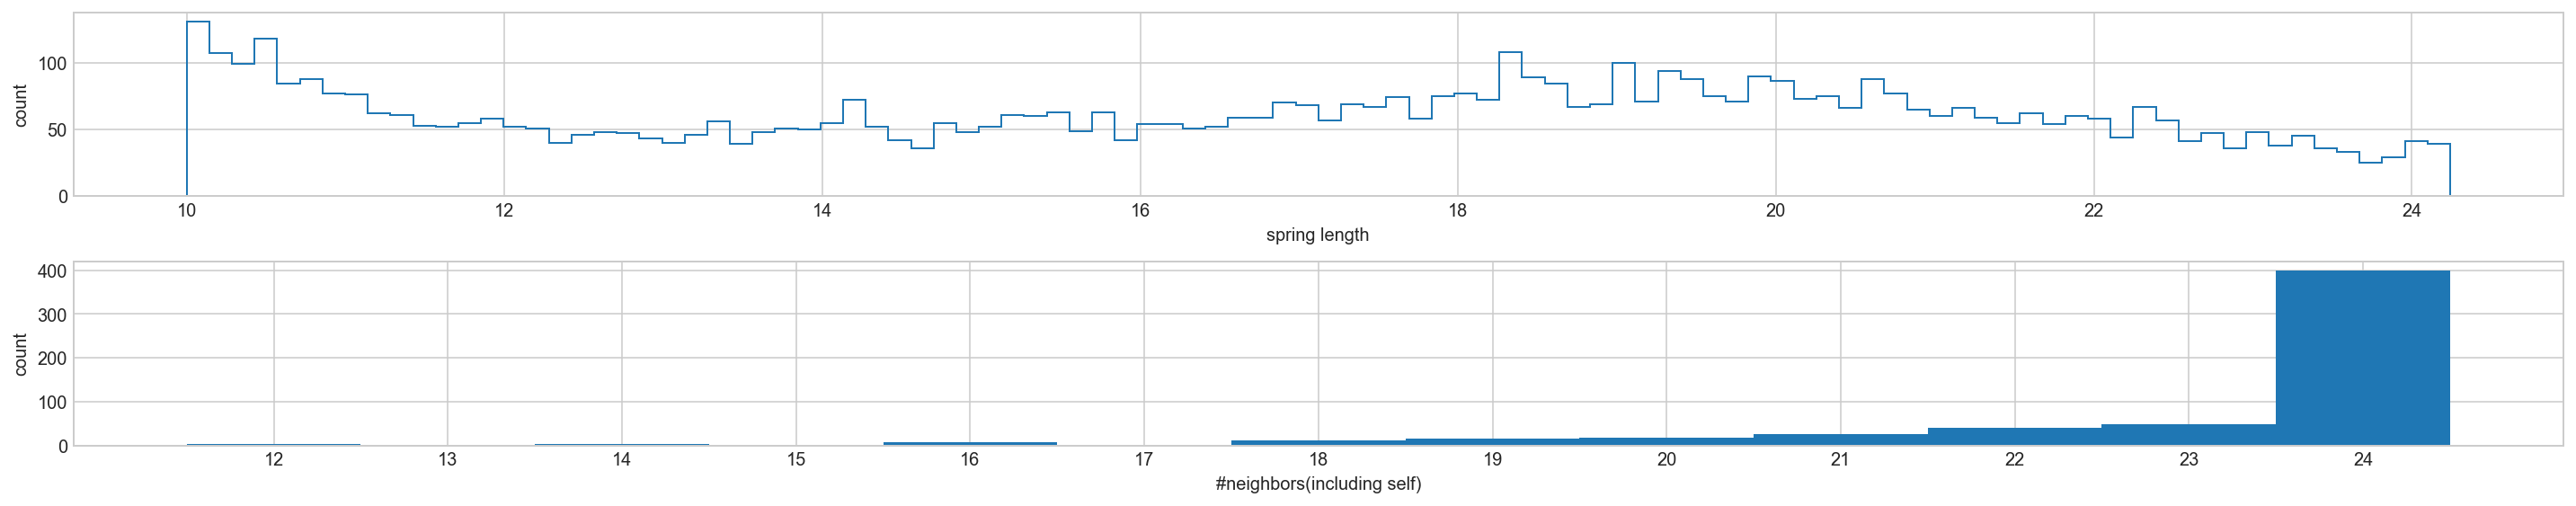

In [150]:
# moi_list = [MomentOfInertial(v_down[v_down[:,0]<=0],(0,0,0),(1,0,0)) for v_down,_ in result]


# KDTree for nearest neighbor search
pcd_leg_tree = o3d.geometry.KDTreeFlann(pcd_leg_d)

# o3d.visualization.draw_geometries([pcd_leg_d,coord_frame])

neighbors = [np.asarray(pcd_leg_tree.search_hybrid_vector_3d(point, radius_knn,max_nn = max_nn)[1]) for point in v_leg_down]

lines_leg = np.vstack([GetEdges(neighbor[:max_nn]) for neighbor in neighbors])

# trim springs outside the leg
mid_points = GetMidpoints(v_leg_down,lines_leg)

is_inside=mesh.ray.contains_points(mid_points)
lines_leg = lines_leg[is_inside]

# is_inner_void = np.logical_and(t>t_inner_cut,r<leg.Radius(t)*r_inner_cut_ratio)
# # is_inner_void = np.logical_and(t>t_inner_cut,r<leg.Radius(t)-16)
# lines_leg = lines_leg[~is_inner_void]


print("#mass: %i"%v_leg_down.shape[0])
print("#springs: %i"%lines_leg.shape[0])

lsd_leg = o3d.geometry.LineSet()
lsd_leg.points = o3d.utility.Vector3dVector(v_leg_down)
lsd_leg.lines = o3d.utility.Vector2iVector(lines_leg)

    
fig, ax = plt.subplots(2,1,figsize=(20,4))

# check the distribution of the distance of the springs
ax[0].hist(np.linalg.norm(v_leg_down[lines_leg[:,0]] - v_leg_down[lines_leg[:,1]],axis=1),bins=100,histtype="step")
ax[0].set_xlabel("spring length")
ax[0].set_ylabel("count")
# check the #of neighbors
neighbor_counts = np.array([len(neighbor) for neighbor in neighbors])
print(f"mean neighbors ={np.mean(neighbor_counts):.1f}")
min_n, max_n = np.amin(neighbor_counts), np.amax(neighbor_counts)
hist,bin_edges,patches =ax[1].hist(neighbor_counts,bins=np.arange(min_n-0.5,max_n+1+0.5, 1))

ax[1].set_xticks(np.arange(min_n,max_n+1, 1))

ax[1].set_xlabel("#neighbors(including self)")
ax[1].set_ylabel("count")

plt.tight_layout()
plt.show()

In [167]:
signed_distance = trimesh.proximity.signed_distance(mesh,v_leg_down)


# ####################### get surface points from mesh ##########################
neighbors_counts = np.array(list(map(len, neighbors))) # number of neighbors per point
# points is near surface if: 
# (1) close to surface or 
# (3) have a fewer than 20 neighbors (including self)
is_surface_leg = (signed_distance<radius_poisson*0.8)+(neighbors_counts<20)
print(f"suface points:{is_surface_leg.sum()/len(is_surface_leg) :.3f}")
# ##################colorize the pcd and lsd ###################################
# color the pointcloud and lines
# cmap = plt.cm.get_cmap('hot')
cmap = plt.cm.get_cmap('hot')

nsd_leg = NormalizeSignedDistance(signed_distance,zero_map_to=0.0) # normalized signed distance for leg points=
# plt.plot(signed_distance,nsd_leg,'.')
leg_colors = cmap(nsd_leg)[:,:3] # drop alpha channel

# leg_colors[is_surface_leg]=(1,0,0) # set surface color
# leg_colors[~is_surface_leg]=(0,1,0) # set interior points color

pcd_leg_d.colors = o3d.utility.Vector3dVector(leg_colors)
# the line colors are the average of the two end points colors
leg_lines_colors = (leg_colors[lines_leg[:,0]]+leg_colors[lines_leg[:,1]])/2
lsd_leg.colors = o3d.utility.Vector3dVector(leg_lines_colors)

o3d.visualization.draw_geometries([lsd_leg, pcd_leg_d,coord_frame])

suface points:0.753


In [55]:
# %load_ext line_profiler
# %lprun -f sample_helper sample_helper()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [146]:

o3d.visualization.draw_geometries([lsd_leg, pcd_leg_d,coord_frame])


In [133]:
xyz = sample_helper()

pcd_leg = o3d.geometry.PointCloud()
pcd_leg.points = o3d.utility.Vector3dVector(xyz)
o3d.visualization.draw_geometries([pcd_leg,coord_frame])


## Generate leg mesh from suface point cloud

In [194]:
########## create dense point cloud of leg surface ##############
v_leg_c0, n_leg_c0 = leg.CrossSectionPoint(-1,40000,flip_normal=True) # left-end surface
v_leg_c1, n_leg_c1 = leg.CrossSectionPoint(2,20000) # right-end surface
v_leg_f, n_leg_f = leg.RandomPoint(400000, surfaceOnly=True) # main surface
v_leg_c = np.vstack((v_leg_c0,v_leg_f,v_leg_c1)) # combine points
n_leg_c = np.vstack((n_leg_c0,n_leg_f,n_leg_c1)) # combine normals

print(v_leg_c.shape) # pre-prune to form sudo-uniformed point cloud
# v_leg_c, n_leg_c = pcu.prune_point_cloud_poisson_disk(
# v=v_leg_c, n=n_leg_c, radius=radius_poisson*0.05, best_choice_sampling=False)
# print(v_leg_c.shape)

pcd_leg = o3d.geometry.PointCloud()
pcd_leg.points = o3d.utility.Vector3dVector(v_leg_c)
pcd_leg.normals = o3d.utility.Vector3dVector(n_leg_c)
# o3d.visualization.draw_geometries([pcd_leg,coord_frame],point_show_normal=True)

####### generate leg mesh using Poisson surface reconstruction #######
print('generate leg mesh: run Poisson surface reconstruction')
mesh_leg, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_leg,depth=6,scale=1.1)
mesh_leg.compute_triangle_normals()
mesh_leg.paint_uniform_color((0.6, 0.6, 0.6))
print(f"mesh_leg = {mesh_leg}")
############# visualize densities ###################################
densities = np.asarray(densities)
density_colors = plt.get_cmap('plasma')(
    (densities - densities.min()) / (densities.max() - densities.min()))
density_colors = density_colors[:, :3]
mesh_leg.vertex_colors = o3d.utility.Vector3dVector(density_colors)
####################################################################
# o3d.visualization.draw_geometries([mesh_leg,pcd_leg])
# o3d.visualization.draw_geometries([mesh_leg],mesh_show_wireframe=True)
################## simplify the leg mesh ############################
mesh_leg_s = mesh_leg.simplify_quadric_decimation(1500)
# print(f"mesh_leg_s = {mesh_leg_s}")
# o3d.visualization.draw_geometries([mesh_leg_s,pcd_leg])
o3d.visualization.draw_geometries([mesh_leg_s],mesh_show_wireframe=True)

NameError: name 'mesh_leg' is not defined

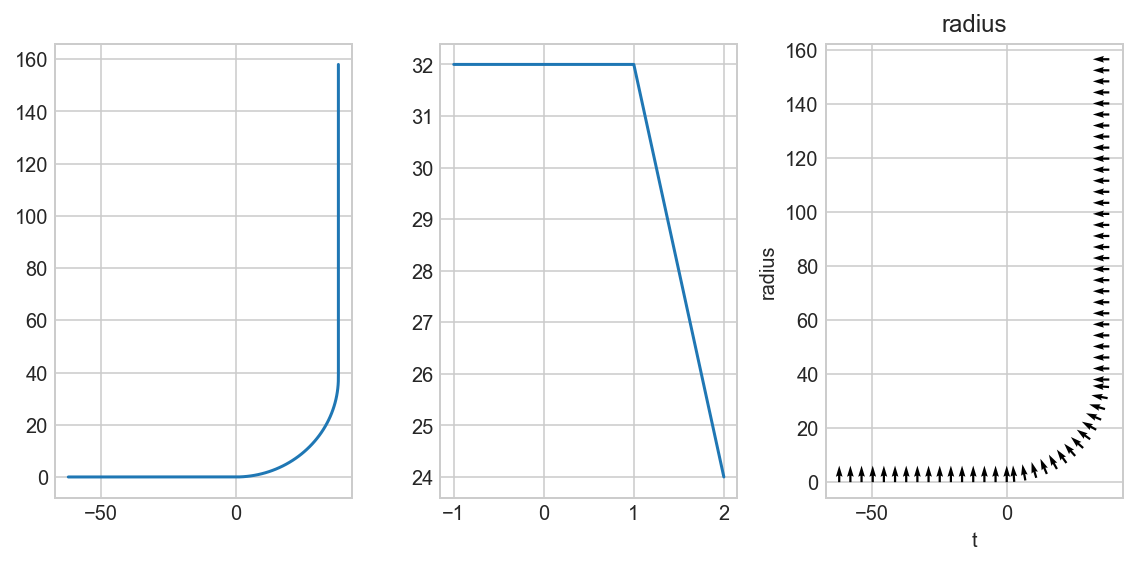

In [6]:
center_line = leg.CenterLine(t_space)
radius = leg.Radius(t_space)

normal = leg.CenterLineNormalDirction(t_space)

fig, axes = plt.subplots(1,3,figsize=(8,4))

axes[0].plot(center_line[:,0],center_line[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('center line')
plt.axis('equal')

axes[1].plot(t_space,radius)
plt.xlabel('t')
plt.ylabel('radius')
plt.title('radius')

axes[2].quiver(center_line[::3,0],center_line[::3,1],normal[::3,0],normal[::3,1])
plt.axis('equal')
plt.xlabel('t')
plt.ylabel('radius')
plt.title('radius')
plt.tight_layout()
plt.show()

## generate spring-mass leg

In [15]:
o3d.visualization.draw_geometries([lsd_leg, pcd_leg_d,coord_frame])

# o3d.visualization.draw_geometries([pcd_leg_d])
# o3d.visualization.draw_geometries([pcd_leg_d])
# o3d.visualization.draw_geometries_with_animation_callback([lsd_leg,coord_frame,pcd_leg_d],rotate_view)
# o3d.visualization.draw_geometries_with_animation_callback([lsd_leg,coord_frame,pcd_leg_d,pcd_leg_centerline],rotate_view,
#                                                          width=1080, height=1080)

In [282]:
# v_leg_down_surface = v_leg_down[is_surface_leg]
# pcd_leg_d_surface = pcd_leg_d.select_by_index(np.where(is_surface_leg)[0])

# # # KDTree for nearest neighbor search
# pcd_leg_surface_tree = o3d.geometry.KDTreeFlann(pcd_leg_d_surface)

# def movePointsToNearestNeighbor(point):
#     num_neighbor,neighbor,dist = pcd_leg_surface_tree.search_hybrid_vector_3d(point, radius_knn,max_nn = 1)
#     return v_leg_down_surface[np.asarray(neighbor[0])]

# mesh_leg_adjusted_vertices = [movePointsToNearestNeighbor(point) for point in np.asarray(mesh_leg.vertices)]

# mesh_leg_adjusted = copy.deepcopy(mesh_leg)
# mesh_leg_adjusted.vertices = o3d.utility.Vector3dVector(mesh_leg_adjusted_vertices)
# print(mesh_leg_adjusted)
# # clean up the mesh
# mesh_leg_adjusted.remove_duplicated_vertices()
# mesh_leg_adjusted.remove_duplicated_triangles()
# mesh_leg_adjusted.remove_degenerate_triangles()
# print(mesh_leg_adjusted)


# o3d.visualization.draw_geometries([mesh_leg_adjusted, pcd_leg_d,lsd_leg,coord_frame],mesh_show_wireframe=True)
# # o3d.visualization.draw_geometries([mesh_leg_adjusted,coord_frame],mesh_show_wireframe=True)
# # o3d.visualization.draw_geometries_with_animation_callback([mesh_leg_adjusted],rotate_view)

geometry::TriangleMesh with 5546 points and 11088 triangles.
geometry::TriangleMesh with 221 points and 438 triangles.


# Body discretization

In [169]:
############################ defineing joints geometry
dy = 260.0/2
rot_ang = 10.0
cylinder_len = 103

dx_front = 0.0
dx_back = dx_front
########################################################
t_axial = Translate((0,0,cylinder_len-half_joint_overlap)) # translate along cylinder
t_zrot = RotateFromVec((0,0,1),np.pi)

t0 = Translate((dx_front,0,dy)).dot(RotateFromVec((0, 1, 0),(90-rot_ang)/180.*np.pi).dot(t_axial))# front left
t1 = Translate((dx_back,0,-dy)).dot(RotateFromVec((0, 1, 0),(90+rot_ang)/180.*np.pi).dot(t_axial))# back left
t2 = Translate((-dx_back,0,-dy)).dot(RotateFromVec((0, 1, 0),(-90-rot_ang)/180.*np.pi).dot(t_zrot).dot(t_axial))# back right
t3 = Translate((-dx_front,0,dy)).dot(RotateFromVec((0, 1, 0),(-90+rot_ang)/180.*np.pi).dot(t_zrot).dot(t_axial))# front right
leg_axes_transform = [t0,t1,t2,t3]


joint_radius = radius_poisson*2.75
# joint_radius = leg_r1
print(f"joint_radius={joint_radius}")
# cylinders for getting the rotation anchor points on the body
cylinders = [trimesh.creation.cylinder(radius=joint_radius, height=joint_overlap, transform=t,sections=60)\
             for t in leg_axes_transform]
##################################################################################################################

joint_radius=27.5


In [170]:
# %load_ext line_profiler
# body_trimesh = trimesh.load("../mesh/mainbody_v2_simplified.stl", use_embree=True)

body_trimesh_path = "../../mesh/soft_body_simplified.obj"
body_trimesh = trimesh.load(body_trimesh_path, use_embree=True)
body_filled_trimesh = trimesh.load(body_trimesh_path, use_embree=True)
# body_filled_o3dmesh = o3d.io.read_triangle_mesh("../mesh/mainbody_v2_simplified_filled.stl")
#####

bounds = body_trimesh.bounds

# convert to integer, type is still float
bounds = np.stack((np.floor(bounds[0]), np.ceil(bounds[1])))

xyz_grid, bounds = createGrid(bounds, dr=radius_grid)
print("bounds=\n", bounds)
xyz_grid_flat = xyz_grid.reshape((-1, 3))


grid_is_inside_flat = body_trimesh.ray.contains_points(xyz_grid_flat)
grid_is_inside = grid_is_inside_flat.reshape(xyz_grid.shape[:-1])

print(f"xyz_grid.shape={xyz_grid.shape}")

############################################

window = np.ones((3, 3, 3))

grid_is_edge = binary_dilation(
    grid_is_inside, window)*~binary_erosion(grid_is_inside, window)

# grid_is_edge = binary_dilation(
#     grid_is_inside)*~binary_erosion(grid_is_inside)
print(f"{grid_is_edge.sum()}")

grid_is_deep_inside = grid_is_inside*~grid_is_edge
# grid_is_deep_inside.sum()


 # grid points near the edge, sampling around may result in outside points
xyz_grid_edge = xyz_grid[grid_is_edge]
 # grid points deep inside the body, sampling around garantees inside points
xyz_grid_inside = xyz_grid[grid_is_deep_inside]
##############################
# print(body_filled_trimesh.is_watertight)
# # make mesh white- ish
# body_trimesh.visual.face_colors = (255,255,255,255)
# body_trimesh.show()

bounds=
 [[-108.  -36. -184.]
 [ 108.   36.  184.]]
xyz_grid.shape=(18, 54, 92, 3)
33797


In [171]:
# pcd_body = o3d.geometry.PointCloud()
# pcd_body.points = o3d.utility.Vector3dVector(xyz_grid_inside)
# o3d.visualization.draw_geometries([pcd_body, coord_frame])

In [172]:
# # list of boolean array for the rotation ids of the body, 4 in total
# body_rot_ids = [cylinder.ray.contains_points(xyz_body) for cylinder in cylinders]
# [sum(ids) for ids in body_rot_ids]

In [173]:
def sample_helper(body_trimesh_path=body_trimesh_path, xyz_grid_edge=xyz_grid_edge,xyz_grid_inside=xyz_grid_inside,
                  radius_poisson=radius_poisson,radius_grid=radius_grid,num_per_grid=num_per_grid):
    # near-edge points candidate
    xyz_edge_candidate = UniformRandomAroundPoints(xyz_grid_edge,
                                                      radius_grid,num_per_grid)
    body_trimesh = trimesh.load(body_trimesh_path, use_embree=True)
    is_edge_candidate = body_trimesh.ray.contains_points(xyz_edge_candidate)
    xyz_edge_candidate = xyz_edge_candidate[is_edge_candidate]
#     print(f"pruning outside points:{xyz_edge_candidate.shape}->{xyz_edge_candidate.shape}")

    # deep-inside points candidate
    xyz_deep_inside_candidate = UniformRandomAroundPoints(xyz_grid_inside,
                                                          radius_grid,num_per_grid)
    # combined points candidate
    xyz_candidate = np.vstack([xyz_deep_inside_candidate, xyz_edge_candidate])

#     print(f"points near surface:{xyz_edge_candidate.shape}")
#     print(f"points deep inside :{xyz_deep_inside_candidate.shape}")
#     print(f"total points       :{xyz_candidate.shape}")
    xyz_body, _ = pcu.prune_point_cloud_poisson_disk(v=xyz_candidate, n=np.ones_like(
    xyz_candidate), radius=radius_poisson, best_choice_sampling=True)
    
    # # check points inside cylinders
    cylinders = [trimesh.creation.cylinder(radius=joint_radius, height=joint_overlap, transform=t,sections=60)\
             for t in leg_axes_transform]
    # list of boolean array for the rotation ids of the body, 4 in total
    body_rot_ids = [cylinder.ray.contains_points(xyz_body) for cylinder in cylinders]
    body_rot_counts = np.array([sum(ids) for ids in body_rot_ids])

    return xyz_body,body_rot_ids,body_rot_counts

In [174]:
# %load_ext line_profiler
# %lprun -f sample_helper sample_helper(body_trimesh_path,xyz_grid_edge,xyz_grid_inside,radius_poisson,radius_grid,num_per_grid)

In [175]:
n_jobs = int(multiprocessing.cpu_count()*0.5)
total_jobs = int(n_jobs*4)
# print(n_jobs,total_jobs)
result = Parallel(n_jobs=n_jobs)(delayed(sample_helper)() for i in range(total_jobs))

In [176]:
counts_arr = np.asarray([counts for _,_,counts in result])

std_arr = np.asarray([c.std() for _,_,c in result])

com_arr = np.asarray([np.mean(xyz, axis=0) for xyz,_,_ in result])
com_norm_arr = np.asarray([np.linalg.norm(np.mean(xyz, axis=0),ord=2) for xyz,_,_ in result])

xyz_body,body_rot_ids,body_rot_counts = result[np.argmin(std_arr)]
xyz_body,body_rot_ids,body_rot_counts = result[np.argmin(com_norm_arr)]

print(xyz_body.shape)
print(body_rot_counts)
with np.printoptions(precision=3, suppress=True):
    print("COM:", np.mean(xyz_body, axis=0))
    
pcd_body = o3d.geometry.PointCloud()
pcd_body.points = o3d.utility.Vector3dVector(xyz_body)
# o3d.visualization.draw_geometries([pcd_body, coord_frame])
# o3d.visualization.draw_geometries_with_animation_callback([pcd_body,coord_frame],rotate_view)

(2440, 3)
[102 107 102 107]
COM: [-0.042 -0.024  0.066]


In [177]:
# ref: https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python
# Faster than is_pareto_efficient_simple, but less readable.
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

In [178]:
pareto_front = is_pareto_efficient(np.stack((std_arr,com_norm_arr)).T,False)
# choose from pareto front, choose the one with the smallest std
# chosen_index = pareto_front[np.argmin(std_arr[pareto_front])]
chosen_index = pareto_front[np.argmin(std_arr[pareto_front]+com_norm_arr[pareto_front])]

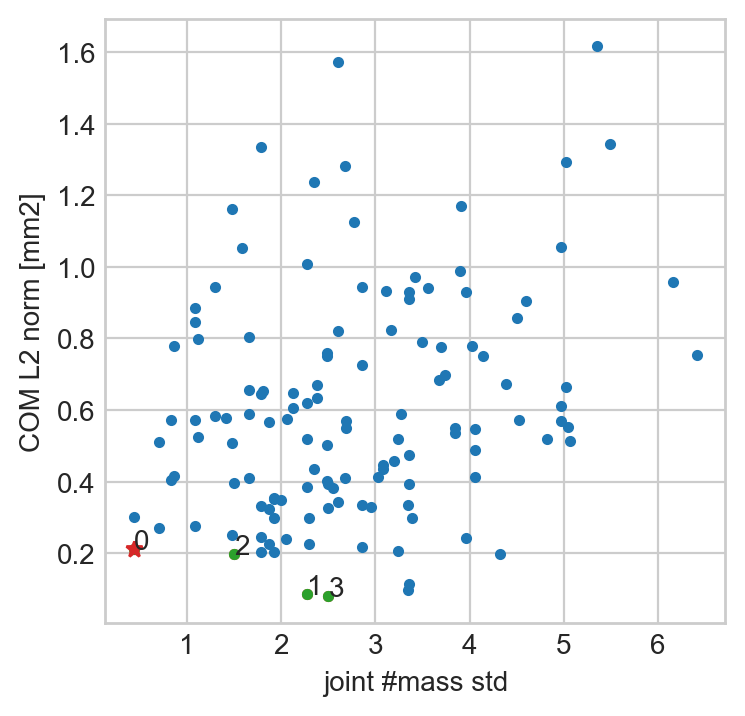

In [179]:
plt.figure(dpi=100,figsize=(4,4))
plt.plot(std_arr,com_norm_arr,'.')
plt.plot(std_arr[pareto_front],com_norm_arr[pareto_front],'.')
plt.plot(std_arr[pareto_front],com_norm_arr[pareto_front],'.')
plt.plot(std_arr[chosen_index],com_norm_arr[chosen_index],'*')    

for rank,idx in enumerate(pareto_front):
    plt.text(std_arr[idx],com_norm_arr[idx],rank)
    
plt.xlabel("joint #mass std")
plt.ylabel("COM L2 norm [mm2]")

plt.show()

In [180]:
xyz_body,body_rot_ids,body_rot_counts = result[chosen_index]
pcd_body = o3d.geometry.PointCloud()
pcd_body.points = o3d.utility.Vector3dVector(xyz_body)
with np.printoptions(precision=3, suppress=True):
    print("COM:", np.mean(xyz_body, axis=0))
print(body_rot_counts)

COM: [ 0.176 -0.027  0.114]
[105 105 104 105]


In [12]:


body_filled_o3dmesh = trimeshToO3dMesh(body_filled_trimesh)
pcd_body = body_filled_o3dmesh.sample_points_uniformly(number_of_points=600000)
# o3d.visualization.draw_geometries([pcd_body])

####### generate leg mesh using Poisson surface reconstruction #######
print('generate leg mesh: run Poisson surface reconstruction')
gmesh_body, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_body,depth=7,scale=1.1)
gmesh_body.compute_triangle_normals()
gmesh_body.paint_uniform_color((0.6, 0.6, 0.6))
print(f"gmesh_body = {gmesh_body}")
############# visualize densities ###################################
densities = np.asarray(densities)
density_colors = plt.get_cmap('plasma')(
    (densities - densities.min()) / (densities.max() - densities.min()))
density_colors = density_colors[:, :3]
gmesh_body.vertex_colors = o3d.utility.Vector3dVector(density_colors)
####################################################################
# o3d.visualization.draw_geometries([gmesh_body,pcd_body])
o3d.visualization.draw_geometries([gmesh_body],mesh_show_wireframe=True)
################## simplify the leg mesh ############################
# gmesh_body_s = gmesh_body.simplify_quadric_decimation(1500)
# print(f"gmesh_body_s = {gmesh_body_s}")
# o3d.visualization.draw_geometries([gmesh_body_s,pcd_leg])
# o3d.visualization.draw_geometries([gmesh_body_s],mesh_show_wireframe=True)

generate leg mesh: run Poisson surface reconstruction
gmesh_body = geometry::TriangleMesh with 22398 points and 44792 triangles.


In [65]:
pcd_body = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(xyz_candidate))
color = np.zeros_like(xyz_candidate)
color[:len(xyz_deep_inside_candidate)] = (0,0,1)
color[len(xyz_deep_inside_candidate):] = (1,0.1,0)
pcd_body.colors = o3d.utility.Vector3dVector(color)
o3d.visualization.draw_geometries([pcd_body,coord_frame])

In [290]:
# pcd_body = o3d.geometry.PointCloud()
# pcd_body.points = o3d.utility.Vector3dVector(xyz_candidate)
# o3d.visualization.draw_geometries([pcd_body,coord_frame])

#mass: 2432
#springs: 27002
COM: [ 0.176 -0.027  0.114]
mean neighbors =23.2


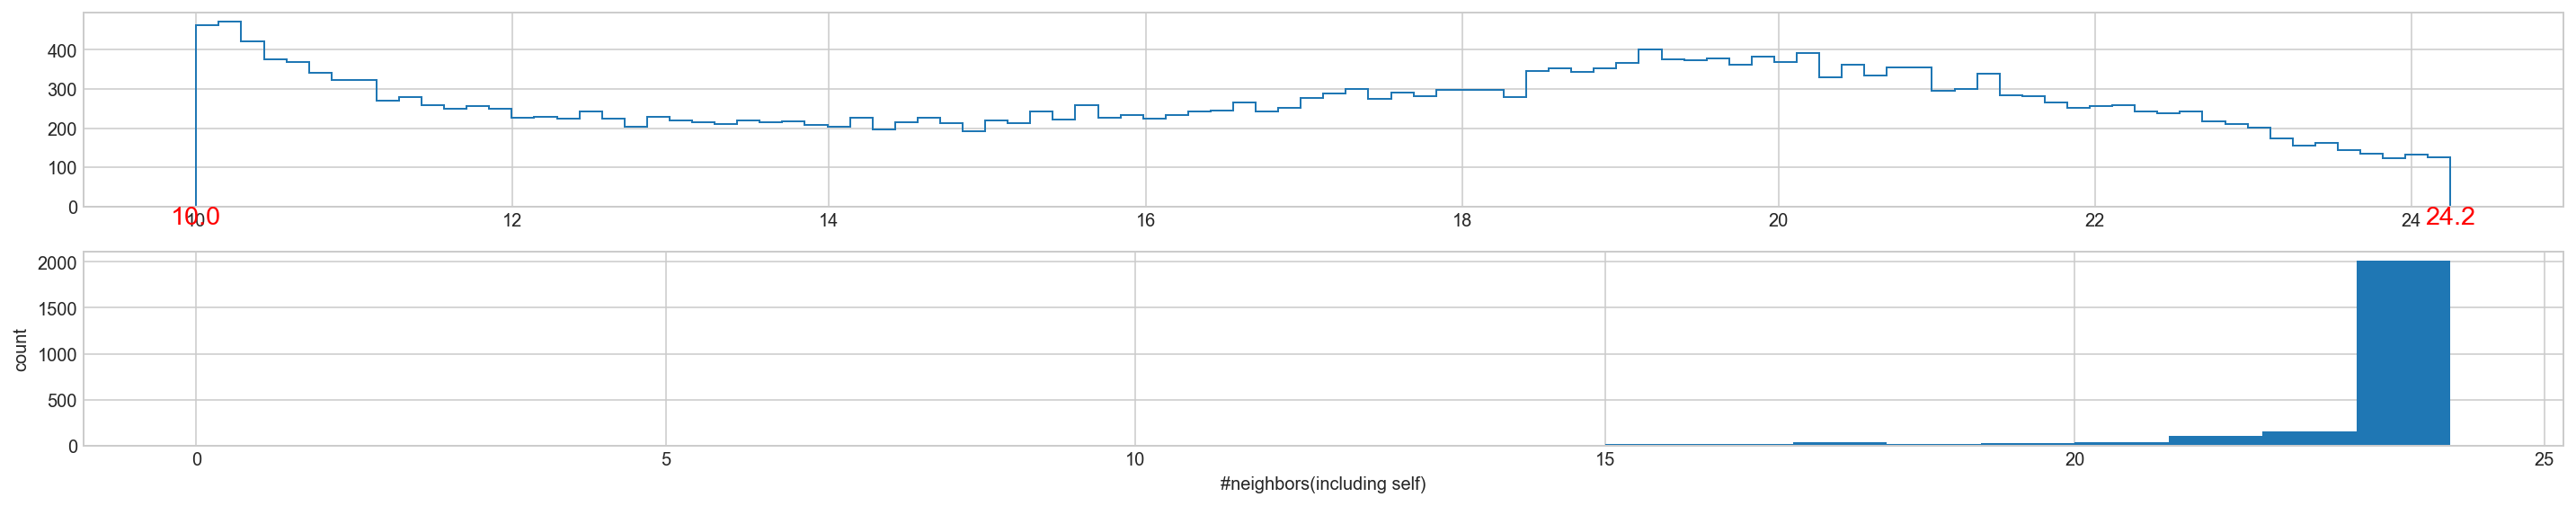

In [181]:
pcd_tree = o3d.geometry.KDTreeFlann(pcd_body)

# o3d.visualization.draw_geometries([pcd_d,coord_frame])

# [k, idx, _] = pcd_tree.search_radius_vector_3d(pcd_d.points[0], radius*np.sqrt(3)+0.1)
# neighbors = [np.asarray(pcd_tree.search_radius_vector_3d(point, radius*(np.sqrt(3)+0.01))[1]) for point in xyz_body]
neighbors = [np.asarray(pcd_tree.search_hybrid_vector_3d(
        point, radius_knn, max_nn=max_nn)[1]) for point in xyz_body]


def GetEdges(neighbor):
    candidate = neighbor[1:]
    self = neighbor[0]
    candidate = candidate[candidate < self]  # to remove redundency
    edges = np.empty((candidate.size, 2), dtype=np.int32)
    edges[:, 0] = self
    edges[:, 1] = candidate
    return edges


lines_body = np.vstack([GetEdges(neighbor[:max_nn]) for neighbor in neighbors])

lsd_body = o3d.geometry.LineSet()
lsd_body.points = o3d.utility.Vector3dVector(xyz_body)
lsd_body.lines = o3d.utility.Vector2iVector(lines_body)

print("#mass: %i" % xyz_body.shape[0])
print("#springs: %i" % lines_body.shape[0])

# lsd_body.paint_uniform_color((0.1,0.1,0.1))
with np.printoptions(precision=3, suppress=True):
    print("COM:", np.mean(xyz_body, axis=0))

# plottig the distribution of the lenght of springs
fig, ax = plt.subplots(2,1,figsize=(20,4))
hist,bin_edges,_ = ax[0].hist(np.linalg.norm(xyz_body[lines_body[:,0]] - xyz_body[lines_body[:,1]],axis=1),bins=100,histtype="step")
ax[0].text(bin_edges[0],0,f"{bin_edges[0]:.1f}",ha="center",va="top",fontsize="x-large",color='r')
ax[0].text(bin_edges[-1],0,f"{bin_edges[-1]:.1f}",ha="center",va="top",fontsize="x-large",color='r')

# check the #of neighbors
neighbor_counts = np.array([len(neighbor) for neighbor in neighbors])
print(f"mean neighbors ={np.mean(neighbor_counts):.1f}")
hist,bin_edges,patches =ax[1].hist(neighbor_counts,bins=max_nn,range=(0,max_nn))
ax[1].set_xlabel("#neighbors(including self)")
ax[1].set_ylabel("count")
plt.tight_layout()
plt.show()

In [182]:
# signed_distance = trimesh.proximity.signed_distance(body_trimesh,xyz_body)
signed_distance = trimesh.proximity.signed_distance(body_filled_trimesh,xyz_body)

# average divergence of the neighbors from a point, (use nb[1:] to exclude the self point)
average_divergence_body = np.linalg.norm(
    [xyz_body[nb[1:]].mean(axis=0)-xyz_body[i] for i,nb in enumerate(neighbors)],axis=1)

neighbors_counts = np.array(list(map(len, neighbors))) # number of neighbors per point

# points is near surface if: 
# (1) close to surface or 
# (2) have a large avg divergence or 
# (3) have a fewer than 26 neighbors (including self)
is_surface_body = (signed_distance<radius_poisson*0.6)#+\
#                  (average_divergence_body>radius_poisson*0.7)+\
#                  (neighbors_counts<26)
print(f"suface points:{is_surface_body.sum()/len(is_surface_body) :.3f}")

# colorize the body
cmap = plt.cm.get_cmap('hot')
colors = cmap(NormalizeSignedDistance(signed_distance,zero_map_to=0.))[:,:3] # drop alpha channel

# colors[is_surface_body]=(1,0,0)
# colors[~is_surface_body]=(0,1,0)

pcd_body.colors = o3d.utility.Vector3dVector(colors)

body_lines_colors = (colors[lines_body[:,0]]+colors[lines_body[:,1]])/2
lsd_body.colors = o3d.utility.Vector3dVector(body_lines_colors)

suface points:0.720


In [183]:
# o3d.visualization.draw_geometries([pcd_body,lsd_body])

# o3d.visualization.draw_geometries_with_animation_callback([lsd_body,coord_frame,pcd_d],rotate_view)
# o3d.visualization.draw_geometries_with_animation_callback([lsd_body,coord_frame,pcd_body],rotate_view,
#                                                          width=1920, height=1080)

In [331]:
xyz_body_surface = xyz_body[is_surface_body]
pcd_body_surface = pcd_body.select_by_index(np.where(is_surface_body)[0])

# # KDTree for nearest neighbor search
pcd_body_surface_tree = o3d.geometry.KDTreeFlann(pcd_body_surface)

def movePointsToNearestNeighbor(point):
    num_neighbor,neighbor,dist = pcd_body_surface_tree.search_hybrid_vector_3d(point, radius_knn,max_nn = 1)
    return xyz_body_surface[np.asarray(neighbor[0])]

mesh_body_adjusted_vertices = [movePointsToNearestNeighbor(point) for point in np.asarray(gmesh_body.vertices)]

mesh_body_adjusted = copy.deepcopy(gmesh_body)
mesh_body_adjusted.vertices = o3d.utility.Vector3dVector(mesh_body_adjusted_vertices)
print(mesh_body_adjusted)
# clean up the mesh
mesh_body_adjusted.remove_duplicated_vertices()
mesh_body_adjusted.remove_duplicated_triangles()
mesh_body_adjusted.remove_degenerate_triangles()
print(mesh_body_adjusted)


o3d.visualization.draw_geometries([mesh_body_adjusted, pcd_body,lsd_body,coord_frame],mesh_show_wireframe=True)
# o3d.visualization.draw_geometries([mesh_body_adjusted,coord_frame],mesh_show_wireframe=True)
# o3d.visualization.draw_geometries_with_animation_callback([mesh_body_adjusted],rotate_view)

geometry::TriangleMesh with 22398 points and 44792 triangles.
geometry::TriangleMesh with 1185 points and 2375 triangles.


# Assemble the parts

In [192]:
def ColorizePcdAndLsd(nsd,pcd,lsd,cmap):
    """
    colorize the pcd (o3d pointcloud) and its corresponding lsd (o3d lineset) 
    given nsd (normalized signed distance) and cmap (plt colormap)
    Input:
        nsd: a normalized signed distance of the pcd, normalized to [0,1]
        pcd: o3d point cloud, representing the mass points
        lsd: o3d lineset, representing the springs
        cmap: plt colormap, ref: https://matplotlib.org/tutorials/colors/colormaps.html
    """
    pcd_color = cmap(nsd)[:,:3] # drop alpha channel
    pcd.colors = o3d.utility.Vector3dVector(pcd_color)
    lines = np.asarray(lsd.lines)
    # the line colors are the average of the two end points colors
    lsd_color =  (pcd_color[lines[:,0]]+pcd_color[lines[:,1]])/2
    lsd.colors = o3d.utility.Vector3dVector(lsd_color)
    return pcd,lsd

def LegAlignTransform(rot_angle):
    """
    first align the rotational axis to z-axis, next rotate about the z axis for rot_angle,
    finally translate along z-axis
    """
    return Translate((0,0,half_joint_overlap), # translate along z-axis
                     np.dot(RotateFromVec((0,0,1),rot_angle),# rotate about the z axis for rot_angle
                            RotateFromVec((0,1,0),-np.pi/2))) # align the rotational axis to z-axis

# define zero_leg_anges as the leg angles when all the legs are pointing towards front
zero_leg_angles = np.array([np.pi/2,np.pi/2,np.pi/2,np.pi/2]) 

leg_angles = np.array([np.pi,np.pi,0,0]) # four leg standing
# leg_angles = np.array([np.pi/3,np.pi/3,-np.pi/3,-np.pi/3])

# leg_angles = np.array([-np.pi/2,-np.pi/2,-np.pi/2,-np.pi/2])
# leg_angles = np.array([np.pi/2,np.pi/2,np.pi/2,np.pi/2])
# leg_angles = np.array([0,0,0,0])

initial_leg_angles = leg_angles-zero_leg_angles

# axis for the body
body_transform = np.array([[0,1,0,0],[0,0,1,0],[1,0,0,0],[0,0,0,1]],dtype=np.float64)

# axis for the joint - body
leg_transform = [np.dot(t,LegAlignTransform(angle)) for t,angle in zip(leg_axes_transform,leg_angles)]

# axis for the legs
aligned_leg_axes_transform = [np.dot(t,RotateFromVec((0,0,1),a))  for t,a in zip(leg_axes_transform,initial_leg_angles)]

# coordinate for the body
coord_body = o3d.geometry.TriangleMesh.create_coordinate_frame(size=60, origin=[0, 0, 0]).transform(body_transform) 

# coordinates for the joint - body
coord_joint_left = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=60, origin=[0, 0, 0]).transform(t) for t in leg_axes_transform]

# coordinate for the joint - legs
coord_joint_right = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=60, origin=[0, 0, 0]).transform(t) for t in aligned_leg_axes_transform]

legs = [o3d.geometry.PointCloud(pcd_leg_d).transform(t) for t in leg_transform]
lsd_legs = [o3d.geometry.LineSet(lsd_leg).transform(t) for t in leg_transform]


cmap_str = ("spring","summer","autumn","winter")
for k in range(len(legs)):
    legs[k],lsd_legs[k] = ColorizePcdAndLsd(nsd_leg,legs[k],lsd_legs[k],plt.cm.get_cmap(cmap_str[k]))

In [193]:
# o3d.visualization.draw_geometries([pcd_body,coord_body]+coord_joint_left+coord_joint_right+legs)
o3d.visualization.draw_geometries([pcd_body,coord_body]+coord_joint_left+legs)

# o3d.visualization.draw_geometries([pcd_body,coord_frame]+coord_joint_right+legs)

# o3d.visualization.draw_geometries(coord_joint_left+legs)
# o3d.visualization.draw_geometries([pcd_body]+coord_joint_left)
# o3d.visualization.draw_geometries([pcd_body,lsd_body]+legs+lsd_legs+coord_joint_left)
# o3d.visualization.draw_geometries_with_animation_callback([pcd_body,lsd_body]+legs+lsd_legs,rotate_view)
# o3d.visualization.draw_geometries([pcd_body]+coord_joint_left+legs)

In [108]:
# # axes_all = [axis_body, axis_leg0, axis_leg1, axis_leg2, axis_leg3]
# axes_all = [coord_frame] + coord_joint_left

# pcd list of parts
pcd_parts = [pcd_body]+legs 

# lst list of parts
lsd_parts = [lsd_body]+lsd_legs

# # transform_all = [transform_body, transform_leg0, transform_leg1, transform_leg2, transform_leg3]
# transform_all = [np.eye(4)] + leg_axes_transform

# list of boolean array for the rotation ids of the body, 4 in total
body_rot_ids = [cylinder.ray.contains_points(xyz_body) for cylinder in cylinders]

# list of np boolean array indicating if point is part of rotational jonit
# leg_rot_ids = [np.asarray(pcd_leg_d.points)[:,0]<-leg_d0,]*len(legs)

pcd_leg_d_points = np.asarray(pcd_leg_d.points)
leg_rot_ids = [
    np.logical_and(pcd_leg_d_points[:, 0] <= -leg_d0,
                   (pcd_leg_d_points[:, 1]**2 +
                   pcd_leg_d_points[:, 2]**2) <= (joint_radius)**2
                   )]*len(legs)
# leg_rot_ids = [cylinder.ray.contains_points(np.asarray(leg.points)) for cylinder,leg in zip(cylinders,legs)]


# xyzs of the components [body,leg,leg,leg,leg]
xyz_parts = [np.asarray(pcd.points) for pcd in pcd_parts]

# the edges of the points start and end index for each part of the component
id_xyz_parts_edges = np.cumsum([0]+[len(xyz) for xyz in xyz_parts])
print(f"id_xyz_parts_edges={id_xyz_parts_edges}")

# lines of the components [body,leg,leg,leg,leg]
lines_parts = [np.asanyarray(lsd.lines) for lsd in lsd_parts]

id_lines_parts_edges = np.cumsum([0]+[len(lines) for lines in lines_parts])
print(f"id_lines_parts_edges={id_lines_parts_edges}")


n_parts = len(xyz_parts) # number of components
print(f"n_parts={n_parts}")
n_joints = len(legs)
print(f"n_joints={n_joints}")

# array of index of the componet for a joint
id_joint_components = np.array([[0,1],[0,2],[0,3],[0,4]])

# list of transform for each joint
joint_transforms_body = leg_axes_transform
joint_transforms_leg = aligned_leg_axes_transform

# the actual points (bool array)
joint_tuples = list(zip(body_rot_ids,leg_rot_ids))

rot_anchor_radius = half_joint_overlap+radius_poisson*0.5
# rot_anchor_radius = 20
print(f"rot_anchor_radius={rot_anchor_radius}")

# anchor points for each of the rotational joint
rot_anchors = [ApplyTransform([[0,0,-rot_anchor_radius],
                               [0,0,rot_anchor_radius]],t) 
               for t in leg_axes_transform]
# print(rot_anchors)

# create pointcloud for anchors
pcd_anchors = o3d.geometry.PointCloud()
pcd_anchors.points = o3d.utility.Vector3dVector(np.vstack(rot_anchors))
pcd_anchors.colors = o3d.utility.Vector3dVector(np.tile((1.,0,0), (len(pcd_anchors.points), 1)))

id_xyz_parts_edges=[   0 2418 2982 3546 4110 4674]
id_lines_parts_edges=[    0 26805 32735 38665 44595 50525]
n_parts=5
n_joints=4
rot_anchor_radius=35.0


In [109]:
[sum(ids) for ids in body_rot_ids],[sum(ids) for ids in leg_rot_ids]

([105, 104, 104, 105], [99, 99, 99, 99])

In [110]:
# pcd_body.paint_uniform_color([0, 1, 0])

# for k in range(4):
#     legs[k].paint_uniform_color([0, 1, 0])
#     np.asarray(legs[k].colors)[leg_rot_ids[k]] = np.array((1,0,0))
#     np.asarray(pcd_body.colors)[body_rot_ids[k]] = np.array((0,0,1))

# o3d.visualization.draw_geometries(legs+[pcd_body],point_show_normal=False)

In [36]:
# axis_size=5
# axis_origin_tri = trimesh.creation.axis(axis_size*2)
# # front left, back left, front right, back right
# axes = [trimesh.creation.axis(axis_size,transform=t) for t in leg_axes_transform]
# body_trimesh.visual.face_colors=(102, 102, 102, 255)
# pcd_body_trimesh = trimesh.points.PointCloud(np.asarray(pcd_body.points))
# pcd_body_trimesh.visual.vertex_colors = (0, 102, 102, 255)

# legs_trimesh = [trimesh.points.PointCloud(np.asarray(leg.points)) for leg in legs]
# for leg_trimesh in legs_trimesh:
#     leg_trimesh.visual.vertex_colors = np.array((255, 1, 1, 255))
    
# for cylinder in cylinders:
#     cylinder.visual.vertex_colors = np.array((255, 1, 1, 255))

# # scene=trimesh.scene.Scene(geometry=axes+[axis_origin_tri,body_trimesh]+cylinders)
# scene=trimesh.scene.Scene(geometry=axes+[axis_origin_tri,pcd_body_trimesh]+cylinders)
# # scene=trimesh.scene.Scene(geometry=axes+[axis_origin_tri]+cylinders+legs_trimesh)
# scene.show()

In [129]:
NUM_POINTS_PER_COORDINATE = 7 # number of points in a coordinate (o,x,y,z,-x,-y,-z)

def GetCoordinateOXYZ(transform):
    coordinate_radius = 16
    o = transform[:3,-1] # origin
    ox = coordinate_radius * transform[:3,0]
    oy = coordinate_radius * transform[:3,1]
    oz = coordinate_radius * transform[:3,2]
    x = o + ox
    y = o + oy
    z = o + oz
    nx = o - ox # negative x
    ny = o - oy # negative y
    nz = o - oz # netative z
    oxyz = np.vstack([o,x,y,z,nx,ny,nz])
    return oxyz

class Coord:# coordinate
    def __init__(s, body_id, transform):
        """
        body_id: body index,e.g. mainbody=0,leg0=1,leg1=2,leg2=3,leg3=4
        transform: 4x4 numpy transform matrix
        """
        s.bodyId = body_id
        s.transform = transform
        s.oxyz = GetCoordinateOXYZ(transform)
        # index offset for the coordinate
        s.id_start = id_xyz_parts_edges[body_id]


coord_list = [
    Coord(0, body_transform),# body axis
    Coord(id_joint_components[0,0],joint_transforms_body[0]), # joint0-body axis
    Coord(id_joint_components[0,1],joint_transforms_leg[0]), # joint0-leg0 axis
    Coord(id_joint_components[1,0],joint_transforms_body[1]), # joint1-body axis
    Coord(id_joint_components[1,1],joint_transforms_leg[1]), # joint1-leg1 axis
    Coord(id_joint_components[2,0],joint_transforms_body[2]), # joint2-body axis
    Coord(id_joint_components[2,1],joint_transforms_leg[2]), # joint2-leg2 axis
    Coord(id_joint_components[3,0],joint_transforms_body[3]), # joint3-body axis
    Coord(id_joint_components[3,1],joint_transforms_leg[3])  # joint3-leg3 axis
]

# oxyzs: list of oxyz from coord_list
oxyzs = [c.oxyz for c in coord_list]

# # pcd of oxyzs
pcd_oxyzs = o3d.geometry.PointCloud()
pcd_oxyzs.points = o3d.utility.Vector3dVector(np.vstack(oxyzs))
pcd_oxyzs.colors = o3d.utility.Vector3dVector(np.tile((1.,0,0), (len(pcd_oxyzs.points), 1)))
# o3d.visualization.draw_geometries([pcd_oxyzs])

In [130]:
# get all colors
pcds = [pcd_body]+legs+[pcd_anchors]+[pcd_oxyzs]
colors_all = np.vstack(list(map(np.asarray,[pcd.colors for pcd in pcds])))

# the acutal points list, arrange as
# [xyz_0,xyz_1,...,xyz_n,]+ [xyz_anchor_0,...,xyz_anchor_m] + [oxyz_0,oxyz_1,..]
xyzs = xyz_parts + rot_anchors + oxyzs

xyz_all = np.vstack(xyzs)

# the count of points in each component of xyzs
points_counts = [len(xyz) for xyz in xyzs]
print(f"points_counts={points_counts}")


# the edges of the points start and end index for each part of the component
# e.g. the idex of xyzs[k] start at id_xyzs_edges[k], and ends at id_xyzs_edges[k+1]
# the rot_anchors [j] start at id_xyzs_edges[n_parts+k], and ends at id_xyzs_edges[n_parts+k+1]
id_xyzs_edges = np.cumsum([0]+[len(xyz) for xyz in xyzs])
print(f"id_xyzs_edges={id_xyzs_edges}")
list(zip(id_xyzs_edges,"body,leg0,leg1,leg2,leg3,anchor0,anchor1,anchor2,anchor3,oxyz_body,\
oxyz_joint0_body,oxyz_joint0_leg0,oxyz_joint1_body,oxyz_joint1_leg1,\
oxyz_joint2_body,oxyz_joint2_leg2,oxyz_joint3_body,oxyz_joint3_leg3,\
the end".split(",")))

points_counts=[2418, 564, 564, 564, 564, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7]
id_xyzs_edges=[   0 2418 2982 3546 4110 4674 4676 4678 4680 4682 4689 4696 4703 4710
 4717 4724 4731 4738 4745]


[(0, 'body'),
 (2418, 'leg0'),
 (2982, 'leg1'),
 (3546, 'leg2'),
 (4110, 'leg3'),
 (4674, 'anchor0'),
 (4676, 'anchor1'),
 (4678, 'anchor2'),
 (4680, 'anchor3'),
 (4682, 'oxyz_body'),
 (4689, 'oxyz_joint0_body'),
 (4696, 'oxyz_joint0_leg0'),
 (4703, 'oxyz_joint1_body'),
 (4710, 'oxyz_joint1_leg1'),
 (4717, 'oxyz_joint2_body'),
 (4724, 'oxyz_joint2_leg2'),
 (4731, 'oxyz_joint3_body'),
 (4738, 'oxyz_joint3_leg3'),
 (4745, 'the end')]

In [131]:
id_xyzs_anchor_start = id_xyzs_edges[n_parts]
print(f"id_xyzs_anchor_start={id_xyzs_anchor_start}")

id_xyzs_oxyz_start = id_xyzs_edges[n_parts+n_joints]
print(f"id_xyzs_oxyz_start={id_xyzs_oxyz_start}")

id_xyzs_joint_oxyz_start = id_xyzs_edges[n_parts+n_joints+1]
print(f"id_xyzs_joint_oxyz_start={id_xyzs_joint_oxyz_start}")

id_xyzs_anchor_start=4674
id_xyzs_oxyz_start=4682
id_xyzs_joint_oxyz_start=4689


In [132]:
def GetNeighborsOXYZ(pcd,oxyz):
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)
    oxyz_neighbors = [np.asarray(pcd_tree.search_knn_vector_3d(
        point,knn=20)[1]) for point in oxyz]
    return oxyz_neighbors
# oxyzs_neighbors = [np.stack(GetNeighborsOXYZ(pcd,oxyz))+id_start 
#                    for pcd,oxyz,id_start in zip(pcd_parts,oxyzs,id_xyzs_edges)]

oxyzs_neighbors = [np.stack(GetNeighborsOXYZ(pcd_parts[c.bodyId],c.oxyz))+c.id_start 
                   for c in coord_list]

In [133]:
def GetEdges(point_id,neighbor):
    """
    Create a edges given the index of a point and the indices of its neighbor
    """
    edges = np.empty((neighbor.size,2),dtype=np.int32)
    edges[:,0]=point_id
    edges[:,1]=neighbor
    return edges


# create oxyz_springs
oxyz_self_springs = []
oxyz_anchor_springs = []
for oxyz,oxyz_neighbor,oxyz_id_start in zip(oxyzs,oxyzs_neighbors,id_xyzs_edges[n_parts+n_joints:]):
    oxyz_id = np.array([oxyz_id_start+k for k in range(NUM_POINTS_PER_COORDINATE)]) # 7 points per coordinate: o,x,y,z,-x,-y,-z
    print(oxyz_id)
    oxyz_anchor_springs.append(
        np.vstack([GetEdges(point_id,neighbor) for point_id,neighbor in zip(oxyz_id,oxyz_neighbor)]))
    oxyz_self_springs.append(oxyz_id[
        np.array((
    (0,1),#ox
    (0,2),#oy
    (0,3),#oz
    (0,4),#o-x
    (0,5),#o-y
    (0,6),#o-z
    (1,2),#xy
    (1,3),#xz
    (1,4),#x-x
    (1,5),#x-y
    (1,6),#x-z
    (2,3),#yz
    (2,4),#y-x
    (2,5),#y-y
    (2,6),#y-z
    (3,4),#z-x
    (3,5),#z-y
    (3,6),#z-z
    (4,5),#-x-y
    (4,6),#-x-z
    (5,6)#-y-z
    ))])
oxyz_self_springs = np.vstack(oxyz_self_springs)
oxyz_anchor_springs = np.vstack(oxyz_anchor_springs)

[4682 4683 4684 4685 4686 4687 4688]
[4689 4690 4691 4692 4693 4694 4695]
[4696 4697 4698 4699 4700 4701 4702]
[4703 4704 4705 4706 4707 4708 4709]
[4710 4711 4712 4713 4714 4715 4716]
[4717 4718 4719 4720 4721 4722 4723]
[4724 4725 4726 4727 4728 4729 4730]
[4731 4732 4733 4734 4735 4736 4737]
[4738 4739 4740 4741 4742 4743 4744]


In [134]:
oxyz_id

array([4738, 4739, 4740, 4741, 4742, 4743, 4744], dtype=int32)

In [233]:
# # ids of the leg at rotational joint
# # assume body index start at id_xyzs_edges[0]
# # leg[k] index start at id_xyzs_edges[k+1], ends at id_xyzs_edges[k+2]
# joints = []
# for k,(body_rot_id,leg_rot_id) in enumerate(joint_tuples):
#     body_rot_id_actual = np.ravel(np.where(body_rot_id))+id_xyzs_edges[0]
#     leg_rot_id_actual = np.ravel(np.where(leg_rot_id))+id_xyzs_edges[1+k]
#     anchors_id = np.arange(id_xyzs_edges[len(xyz_parts)+k],id_xyzs_edges[len(xyz_parts)+k+1])
#     # (left_ids,right_ids,anchors_id)
#     joints.append([body_rot_id_actual,leg_rot_id_actual,anchors_id])

# joints_list = [[m.tolist() for m in joint] for joint in joints]

In [135]:
def CreateJointLines(id_0, id_1, id_joint):
    """
    return the joint lines(rotation springs) defined by a joint 
    input:
        id_0: m numpy indices of the first points
        id_1: n numpy indices of the second points
        id_joint: 2 indices of the end points of a joint
    """
    return np.vstack([np.column_stack([id_0, [id_joint[0]]*len(id_0)]), # left  (id_0) - axis_0
            np.column_stack([id_1, [id_joint[0]]*len(id_1)]), # left  (id_0) - axis_1
            np.column_stack([id_0, [id_joint[1]]*len(id_0)]), # right (id_1) - axis_0
            np.column_stack([id_1, [id_joint[1]]*len(id_1)])]) # right (id_1) - axis_1

def CreateJointFrictionSpring(id_0, id_1,num_spring_per_mass= 40):
    """
    return the friction springs defined by a joint 
    input:
        id_0: m numpy indices of the first points
        id_1: n numpy indices of the second points
    """
    max_size = int((len(id_0)+len(id_1))*num_spring_per_mass/2)
    frictionSpring = np.vstack([np.column_stack([[id_0_k]*len(id_1),id_1]) for id_0_k in id_0])
    if frictionSpring.shape[0]>max_size:
        frictionSpring = frictionSpring[np.random.choice(frictionSpring.shape[0], max_size, replace=False)]
    return frictionSpring

In [136]:
class Joint:
    def __init__(s, left, right, anchor):
        s.left = np.copy(left)  # indices of the left mass
        s.right = right  # indices of the right mass
        s.anchor = anchor  # indices of the two ends of the center of rotation
        s.rotSpring = CreateJointLines(
            s.left, s.right, s.anchor)  # rotation spring
        s.friSpring = CreateJointFrictionSpring(
            s.left, s.right)  # friction spring
        s.leftCoord = None
        s.righCoord = None

    def __repr__(s):
        s_rotationSpring = np.array2string(
            s.rotSpring, threshold=10, edgeitems=2).replace("\n", ",")
        s_frictionSpring = np.array2string(
            s.friSpring, threshold=10, edgeitems=2).replace("\n", ",")

        return f"{{left({len(s.left)}):  {np.array2string(s.left,threshold=10,edgeitems=5)}\n" +\
               f" right({len(s.right)}): {np.array2string(s.right,threshold=10,edgeitems=5)}\n" +\
            f" anchor(2): {s.anchor}\n" +\
               f" leftCoord: {s.leftCoord}\n" +\
            f" righCoord: {s.righCoord}\n" +\
            f" rotSpring({len(s.rotSpring)}):{s_rotationSpring}\n" +\
            f" friSpring({len(s.friSpring)}):{s_frictionSpring}}}"

    def tolist(s):
        return [s.left.tolist(), s.right.tolist(), s.anchor.tolist(), int(s.leftCoord), int(s.righCoord)]

In [137]:
# ids of the leg at rotational joint
# assume body index start at id_xyzs_edges[0]
# leg[k] index start at id_xyzs_edges[k+1], ends at id_xyzs_edges[k+2]
joints = []
for k,(body_rot_id,leg_rot_id) in enumerate(joint_tuples):
    body_rot_id_actual = np.ravel(np.where(body_rot_id))+id_xyzs_edges[0]
    leg_rot_id_actual = np.ravel(np.where(leg_rot_id))+id_xyzs_edges[1+k]
    anchors_id = np.arange(id_xyzs_edges[len(xyz_parts)+k],id_xyzs_edges[len(xyz_parts)+k+1])
    # (left_ids,right_ids,anchors_id)
    
    joints.append(Joint(body_rot_id_actual,leg_rot_id_actual,anchors_id))

for k in range(n_joints):
    joints[k].leftCoord = id_xyzs_joint_oxyz_start+NUM_POINTS_PER_COORDINATE*2*k
    joints[k].righCoord = id_xyzs_joint_oxyz_start+(NUM_POINTS_PER_COORDINATE*2)*k + NUM_POINTS_PER_COORDINATE
    
joints_list = [joint.tolist() for joint in joints]
joints

[{left(105):  [  22   26   27   40   51 ... 2326 2340 2384 2407 2414]
  right(99): [2421 2425 2434 2438 2442 ... 2968 2970 2973 2976 2979]
  anchor(2): [4674 4675]
  leftCoord: 4689
  righCoord: 4696
  rotSpring(408):[[  22 4674], [  26 4674], ..., [2976 4675], [2979 4675]]
  friSpring(4080):[[1810 2903], [1847 2637], ..., [ 693 2665], [ 341 2650]]},
 {left(104):  [  68  114  135  149  255 ... 2206 2226 2244 2368 2388]
  right(99): [2985 2989 2998 3002 3006 ... 3532 3534 3537 3540 3543]
  anchor(2): [4676 4677]
  leftCoord: 4703
  righCoord: 4710
  rotSpring(406):[[  68 4676], [ 114 4676], ..., [3540 4677], [3543 4677]]
  friSpring(4060):[[1428 3254], [1769 3108], ..., [1000 3406], [ 292 3304]]},
 {left(104):  [  10   89  121  125  129 ... 2354 2366 2367 2405 2413]
  right(99): [3549 3553 3562 3566 3570 ... 4096 4098 4101 4104 4107]
  anchor(2): [4678 4679]
  leftCoord: 4717
  righCoord: 4724
  rotSpring(406):[[  10 4678], [  89 4678], ..., [4104 4679], [4107 4679]]
  friSpring(4060):[

In [138]:
# array of (the index of the axis points of a joint)
id_joint_keypoints = np.vstack([joint.anchor for joint in joints])
print(f"id_joint_keypoints:\n{id_joint_keypoints}")
# [body_lines,leg_lines_0,leg_lines_1,leg_lines_2,leg_lines_3]
lines_component_list = [lines + id_start for lines,
              id_start in zip(lines_parts, id_xyzs_edges)]

lines_joint_rotation = np.vstack([joint.rotSpring for joint in joints])

lines_joint_friction = np.vstack([joint.friSpring for joint in joints])
# list of all the edges of the assembly

lines_all_list = lines_component_list+[id_joint_keypoints,lines_joint_rotation,lines_joint_friction,
                                       oxyz_self_springs,oxyz_anchor_springs]
lines_all = np.vstack(lines_all_list)

id_lines_edges = np.cumsum([0]+[len(lines) for lines in lines_all_list])
print(f"id_lines_edges:{id_lines_edges}")
id_lines_edges[n_parts]

list(zip(id_lines_edges,"body,leg0,leg1,leg2,leg3,anchors,rotsprings,\
fricsprings,oxyz_self_springs,oxyz_anchor_springs,the end".split(',')))

id_joint_keypoints:
[[4674 4675]
 [4676 4677]
 [4678 4679]
 [4680 4681]]
id_lines_edges:[    0 26805 32735 38665 44595 50525 50529 52157 68437 68626 69886]


[(0, 'body'),
 (26805, 'leg0'),
 (32735, 'leg1'),
 (38665, 'leg2'),
 (44595, 'leg3'),
 (50525, 'anchors'),
 (50529, 'rotsprings'),
 (52157, 'fricsprings'),
 (68437, 'oxyz_self_springs'),
 (68626, 'oxyz_anchor_springs'),
 (69886, 'the end')]

In [139]:
# # np.asarray(pcd_body.colors)[np.sum(body_rot_ids,axis = 0,dtype=bool)]=(0,255,0)
# for k in range(4):
#     np.asarray(legs[k].colors)[leg_rot_id] = (0,255,0)
#     np.asarray(pcd_body.colors)[body_rot_ids[k]] = (0,0,255)

In [141]:
pcd_assembly = o3d.geometry.PointCloud()
pcd_assembly.points = o3d.utility.Vector3dVector(xyz_all)
pcd_assembly.colors = o3d.utility.Vector3dVector(colors_all)

lsd_assembly = o3d.geometry.LineSet()
lsd_assembly.points = o3d.utility.Vector3dVector(xyz_all)
# lsd_assembly.lines = o3d.utility.Vector2iVector(lines_all[id_lines_edges[n_parts]:])

lsd_assembly.lines = o3d.utility.Vector2iVector(lines_all)

# lsd_assembly.lines = o3d.utility.Vector2iVector(lines_all[id_lines_edges[6]:id_lines_edges[7]]) #joint rotspring
# lsd_assembly.lines = o3d.utility.Vector2iVector(lines_all[id_lines_edges[7]:id_lines_edges[8]]) #joint friciton spring


# lsd_assembly.lines = o3d.utility.Vector2iVector(oxyz_self_springs)
# lsd_assembly.lines = o3d.utility.Vector2iVector(oxyz_anchor_springs)
# lsd_assembly.lines = o3d.utility.Vector2iVector(np.vstack((oxyz_anchor_springs,oxyz_self_springs)))

lsd_assembly.colors = o3d.utility.Vector3dVector((colors_all[lines_all[:,0]]+colors_all[lines_all[:,1]])/2)
# o3d.visualization.draw_geometries([pcd_assembly,lsd_assembly,coord_frame]+coord_joint_left)

o3d.visualization.draw_geometries_with_animation_callback([pcd_assembly,lsd_assembly,coord_body]+coord_joint_left,rotate_view)


In [142]:
print("#springs =%i"%(len(lines_all)))
print("#mass =%i"%(len(xyz_all)))

# # KDTree for nearest neighbor search
# pcd_assembly_tree = o3d.geometry.KDTreeFlann(pcd_assembly)

# # o3d.visualization.draw_geometries([pcd_leg_d,coord_frame])

# neighbors = [np.asarray(pcd_assembly_tree.search_radius_vector_3d(point, radius_knn)[1])
#              for point in xyz_all]
# # neighbors = [np.asarray(pcd_assembly_tree.search_hybrid_vector_3d(point, radius_knn,max_nn = 27))[1] for point in xyz_all]

# # check the distance of the springs
# fig, ax = plt.subplots(figsize=(20,2))
# hist,bin_edges,_ =ax.hist(np.linalg.norm(xyz_all[lines_all[:,0]] - xyz_all[lines_all[:,1]],axis=1),bins=200)
# ax.text(bin_edges[0],0,f"{bin_edges[0]:.1f}",ha="center",va="top",fontsize="x-large",color='r')
# ax.text(bin_edges[-1],0,f"{bin_edges[-1]:.1f}",ha="center",va="top",fontsize="x-large",color='r')
# ax.set_xlabel("spring length")
# ax.set_ylabel("count")
# plt.show()

# neighbor_counts = np.array([len(neighbor) for neighbor in neighbors])
# print(f"mean neighbors ={np.mean(neighbor_counts)}")
# fig, ax = plt.subplots(figsize=(20,2))
# hist,bin_edges,patches =ax.hist(neighbor_counts,bins=28,range=(0,28))
# ax.set_xlabel("#neighbors (including self)")
# ax.set_ylabel("count")
# # ax.text(surface_neighbor_threshold,0,f"{surface_neighbor_threshold}",ha="center",va="top",fontsize="x-large",color='r')
# plt.show()



# # average divergence of the neighbors from a point
# average_divergence = np.linalg.norm([xyz_all[n].mean(axis=0)-xyz_all[n[0]] for n in neighbors],axis=1)
# fig, ax = plt.subplots(figsize=(20,2))
# hist,bin_edges,patches =ax.hist(average_divergence,bins=100)
# ax.set_xlabel("mean divergence of neighbors (including self)")
# ax.set_ylabel("count")
# plt.show()

# # is_suface is boolean array to specify wether the point is near the surface, useful for applying contraints
# surface_neighbor_threshold = int(max_nn*0.9)
# is_suface = np.logical_or(average_divergence>0.6*radius_poisson,neighbor_counts<surface_neighbor_threshold)
# is_suface[id_xyzs_edges[n_parts]:]=False # only body parts are considered
# print(f"%surface points = {is_suface.sum()/len(is_suface)*100:.0f}%")

#springs =69886
#mass =4745


In [143]:
is_suface = np.zeros(len(xyz_all),dtype=bool)
is_suface[id_xyzs_edges[0]:id_xyzs_edges[1]]=is_surface_body
for k in range(4):
    is_suface[id_xyzs_edges[1+k]:id_xyzs_edges[2+k]]=is_surface_leg

colors_all_check = np.copy(colors_all)
colors_all_check[is_suface]=(1,0.2,0.2)
colors_all_check[~is_suface]=(0,0,0.1)

pcd_assembly.colors = o3d.utility.Vector3dVector(colors_all_check)

lsd_assembly.colors = o3d.utility.Vector3dVector((colors_all_check[lines_all[:,0]]+colors_all_check[lines_all[:,1]])/2)

# o3d.visualization.draw_geometries([pcd_assembly,lsd_assembly,coord_frame]+coord_joint_left)
# o3d.visualization.draw_geometries([pcd_assembly,coord_frame]+coord_joint_left)

# o3d.visualization.draw_geometries([pcd_assembly])

# o3d.visualization.draw_geometries([pcd_assembly,lsd_assembly])

# o3d.visualization.draw_geometries([pcd_assembly,coord_frame]+coord_joint_left)

# export assembly

In [145]:
# transoformed so that z is pointed up
xyz_all_trans = ApplyTransform(xyz_all, 
               np.array([[0,1,0],
                         [0,0,1],
                         [1,0,0]]).T)

# xyz_all_trans = xyz_all.copy() # stand pose

min_bound = xyz_all_trans.min(axis=0)

# transoformed ofset scaled mm->m
xyz_all_trans = (xyz_all_trans + np.array([0,0,0-min_bound[-1]+0]))/1000

# rotation about z
# xyz_all_trans =ApplyTransform(xyz_all_trans, RotateFromVec([0,0,1],-20*np.pi/180))


pcd_assembly = o3d.geometry.PointCloud()
pcd_assembly.points = o3d.utility.Vector3dVector(xyz_all_trans)
pcd_assembly.colors = o3d.utility.Vector3dVector(colors_all)
coord_frame_mm = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.06, origin=[0, 0, 0])
# o3d.visualization.draw_geometries([pcd_assembly,coord_frame_mm])

data = [
    xyz_all_trans.tolist(),
    lines_all.tolist(),
    is_suface.tolist(),
    id_xyzs_edges.tolist(),
    id_lines_edges.tolist(),
    colors_all.tolist(),
    joints_list
]
print(xyz_all_trans.min(axis=0))
print(xyz_all_trans.max(axis=0))
print(xyz_all_trans.shape)
print(lines_all.shape)


# https://stackoverflow.com/questions/43442194/how-do-i-read-and-write-with-msgpack
    
# Write msgpack file
with open('../data.msgpack', 'wb') as outfile:
    msgpack.pack(data, outfile)

[-0.18581903 -0.17143879  0.        ]
[0.18581903 0.17143879 0.19153434]
(4745, 3)
(69886, 2)


In [1086]:
# Read msgpack file
with open('../data.msgpack','rb') as data_file:
    # data_loaded = json.load(data_file)
    data_loaded = msgpack.unpack(data_file)
print(len(data_loaded[1]))

60767


In [76]:
# x = b'\x01\x02'

# dt = np.dtype(np.uint16)
# dt = dt.newbyteorder('>')
# np.frombuffer(x,dtype=dt)